In [1]:
import sys
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.insert(0, '../')
#sys.path.insert(1, '/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages')
from few.trajectory.flux import RunSchwarzEccFluxInspiral
from few.amplitude.romannet import RomanAmplitude
from few.amplitude.interp2dcubicspline import Interp2DAmplitude
from few.waveform import FastSchwarzschildEccentricFlux, SlowSchwarzschildEccentricFlux
from few.utils.overlap import get_overlap, get_mismatch
from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.waveform import SchwarzschildEccentricWaveformBase
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.summation.directmodesum import DirectModeSum

# Fast and Accurate EMRI Waveforms

Here we provide a set of examples for creating EMRI waveforms as a whole; looking at separate creation pieces (trajectory, amplitude, summation, etc.); and creating your own module to build directly into this framework. For details on the specifics of our waveforms like constructions used and generally methodology, we refer you to our paper (TODO: add arxiv) and the [package documentation](https://mikekatz04.github.io/FastEMRIWaveforms/). 

If you use any work from package please cite our paper (TODO: add arxiv). Additionally please cite any additional work for each module used by calling the `citation` attribute on the module class:

In [2]:
wave = FastSchwarzschildEccentricFlux()
print(wave.citation)


                Temp citation for this paper
                
                @article{Hughes:2005qb,
                    author = "Hughes, Scott A. and Drasco, Steve and Flanagan, Eanna E. and Franklin, Joel",
                    title = "{Gravitational radiation reaction and inspiral waveforms in the adiabatic limit}",
                    eprint = "gr-qc/0504015",
                    archivePrefix = "arXiv",
                    doi = "10.1103/PhysRevLett.94.221101",
                    journal = "Phys. Rev. Lett.",
                    volume = "94",
                    pages = "221101",
                    year = "2005"
                }
            

                @article{Chua:2018woh,
                    author = "Chua, Alvin J.K. and Galley, Chad R. and Vallisneri, Michele",
                    title = "{Reduced-order modeling with artificial neurons for gravitational-wave inference}",
                    eprint = "1811.05491",
                    archivePrefix = "arXiv",
    

## Full EMRI Waveforms

In the section, we will describe how to create EMRI waveforms with both our fast and slow EMRI waveform model. The current full models include [`FastSchwarzschildEccentricFlux`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.FastSchwarzschildEccentricFlux) and [`SlowSchwarzschildEccentricFlux`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.SlowSchwarzschildEccentricFlux). These are fast and slow versions of models that evolve eccentric flux-based trajectories in a Schwarzschild background. The fast model can be run exactly as shown here on CPUs or GPUs by providing the correct initialization arguments. 

The waveform model produces $h(t) = h_p - ih_c(t) $. It takes as arguments $\{M, \mu, p_0, e_0, \Phi_{\phi,0}, \Phi_{r, 0}\}$. $M$ is the larger mass ($M_\odot$), $\mu$ is the compact object mass ($M_\odot$), $p_0$ is the initial semi-latus rectum (dimensionless), $e_0$ is the initial eccentricity, and the final two are the initial phases in $\phi, r$.

### [FastSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.FastSchwarzschildEccentricFlux)

The fast waveform generates sparse trajectories with ~100 points. Amplitudes for all modes are then determined with ROMAN network. From these amplitudes, we perform mode selection to remove modes that do not contribute significantly to the waveform. The remaining modes and phases are then interpolated with cubic splines. In one final step, the amplitude, phase, and angular harmonic information is then combined with an interpolated summation. 

* Trajectory Module: [`RunSchwarzEccFluxInspiral`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.trajectory.flux.RunSchwarzEccFluxInspiral)

* Amplitude Module: [`RomanAmplitude`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.amplitude.romannet.RomanAmplitude)

* Summation Module: [`InterpolateModeSum`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.summation.interpolatedmodesum.InterpolatedModeSum)

* Mode Selection: [`ModeSelector`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.utils.modeselector.ModeSelector)

* Angular Harmonics: [`GetYlms`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.utils.ylm.GetYlms)


In [ ]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e3),  # all of the trajectories will be well under len = 1000
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_input_len": int(1e3),  # all of the trajectories will be well under len = 1000
    "use_gpu": use_gpu  # GPU is available in this class
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu,  # GPU is availabel for this type of summation
    "pad_output": True,
}

few = FastSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

In [ ]:
# parameters
M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.4
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
dt = 10.0

wave = few(M, mu, p0, e0, theta, phi, dt=dt, T=1.0)  #  assumes dt = 10.0 for max T = 1.0 year

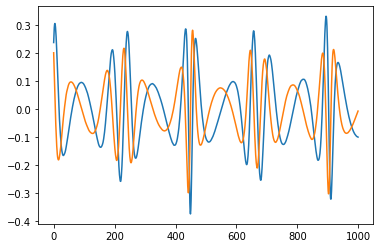

In [4]:
dt = 10.0
t = np.arange(len(wave)) * dt

plt.plot(wave.real[:1000])
plt.plot(wave.imag[:1000])

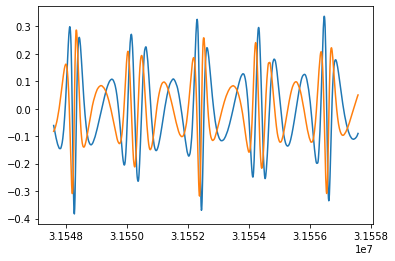

In [5]:
plt.plot(t[-1000:], wave.real[-1000:])
plt.plot(t[-1000:], wave.imag[-1000:])

To get shorter waveforms, you can provide the `T` kwarg for the function call. This is the observation time in years. You can also adjust `dt`. This is the time change in samples in seconds.

In [3]:
# parameters
M = 1e5
mu = 1e1
p0 = 8.0
e0 = 0.1
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle

dt = 10.0 # seconds
T = 0.1  # years
wave = few(M, mu, p0, e0, theta, phi, T=T, dt=dt)

# we can check how many harmonic modes are kept

t = np.arange(len(wave))*dt
plt.plot(t, wave.real)
plt.plot(t, wave.imag)

dt*(len(wave) - 1)

../few/utils/baseclasses.py:266: UserWarning: With p0 = 8.0 < 10, the user must be careful the trajectory does not lie above the p0=10 e0=0.7 curve.
  p0


> /Users/michaelkatz/Research/FastEMRIWaveforms/few/utils/baseclasses.py(468)__call__()
-> num_pts_pad = int((T - t[0]) / dt) + 1 - num_pts
(Pdb) num_pts
8534
(Pdb) p t[-1]
85334.33650746831
(Pdb) p t[0]
0.0
(Pdb) int((t[-1] - t[0]) / dt)
8533
(Pdb) t[-1] - t[0]
85334.33650746831
(Pdb) ((t[-1] - t[0]) / dt)
8533.43365074683
(Pdb) n
> /Users/michaelkatz/Research/FastEMRIWaveforms/few/utils/baseclasses.py(473)__call__()
-> self.num_pts, self.num_pts_pad = num_pts, num_pts_pad
(Pdb) p num_pts_pad
307048
(Pdb) num_pts + num_pts_pad
315582
(Pdb) T
3155814.97635456
(Pdb) ((num_pts + num_pts_pad) - 1)*dt
3155810.0
(Pdb) q


BdbQuit: 

The `eps` kwarg will change the mode content of the waveform. Lowering it add modes. Increasing it will remove modes. The default is $10^{-5}$. This is generally recommended as good setting for good overlaps across the available parameter space.

In [ ]:
dt = 15.0 # seconds
T = 0.005  # years
wave1 = few(M, mu, p0, e0, theta, phi, T=T, dt=dt, eps=1e-5)  # default

# we can check how many harmonic modes are kept
modes1 = few.num_modes_kept

wave2 = few(M, mu, p0, e0, theta, phi, T=T, dt=dt, eps=1e-2)

modes2 = few.num_modes_kept

plt.plot(wave1.real, label=r'$10^{-2}$')
plt.plot(wave2.real, label=r'$10^{-2}$')

# we can also compute the mismatch when removing modes
mm = get_mismatch(wave1, wave2)

# we can check how many modes were kept
print('wave used {} modes. wave2 used {} modes. The mismatch was {}'.format(modes1, modes2, mm))

### [SlowSchwarzschildEccentricFlux](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.waveform.SlowSchwarzschildEccentricFlux)

The slow waveform generates dense trajectories with at every `dt` seconds within `T` years. Amplitudes for all modes are then determined with a 2d bicubic spline over semi-latus rectum and eccentricity for each mode. This is done at each dense time step. We do not perform mode selection because this is the slow and most accurate model against which we compare the fast model. The final summation is a direct combination of phase, amplitude, and Ylm information at each dense timestep. 

**Note**: One thing to pay attention to with the slow waveform is batch size. This is determined by memory limits. Usually anything under ~10000 is fine.

* Trajectory Module: [`RunSchwarzEccFluxInspiral`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.trajectory.flux.RunSchwarzEccFluxInspiral)

* Amplitude Module: [`Interp2DAmplitude`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.amplitude.interp2dcubicspline.Interp2DAmplitude)

* Summation Module: [`DirectModeSum`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.summation.directmodesum.DirectModeSum)

* Mode Selection: None

* Angular Harmonics: [`GetYlms`](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html#few.utils.ylm.GetYlms)


In [ ]:
use_gpu = False

# keyword arguments for inspiral generator (RunSchwarzEccFluxInspiral)
inspiral_kwargs={
        "DENSE_STEPPING": 1,  # we want a sparsely sampled trajectory
        "max_init_len": int(1e7),  # dense stepping trajectories
    }

# keyword arguments for inspiral generator (RomanAmplitude)
amplitude_kwargs = {
    "max_input_len": int(1e4),  # this must be >= batch_size
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "assume_positive_m": False  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "use_gpu": use_gpu  # GPU is availabel for this type of summation
}

slow = SlowSchwarzschildEccentricFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)

# parameters
T = 0.005  # years
dt = 15.0 # seconds
M = 1e6
mu = 1e1
p0 = 8.0
e0 = 0.2
theta = np.pi/3  # polar viewing angle
phi = np.pi/4  # azimuthal viewing angle
batch_size = int(1e4)

slow_wave = slow(M, mu, p0, e0, theta, phi, T=T, dt=dt, batch_size=batch_size)

../few/utils/baseclasses.py:266: UserWarning: With p0 = 8.0 < 10, the user must be careful the trajectory does not lie above the p0=10 e0=0.7 curve.
  p0


In [ ]:
fast_wave = few(M, mu, p0, e0, theta, phi, T=T, dt=dt)

plt.plot(slow_wave.real)
plt.plot(fast_wave.real)
print('Length check:', len(fast_wave), len(slow_wave))
print('Mismatch:', get_mismatch(slow_wave, fast_wave))

## Trajectory Module

The trajectory module generates orbital and phase trajectories, $G(t)$, for an EMRI orbit:  

\begin{equation}
    G(t) = \{p(t), e(t), \iota(t), \Phi_\phi(t), \Phi_\theta(t), \Phi_r(t)\}
\end{equation}

with inputs $M, \mu, p_0, e_0, \iota_0, \Phi_{\phi,0}, \Phi_{\theta,0}, \Phi_{r, 0}$. $M$ is the larger mass ($M_\odot$), $\mu$ is the compact object mass ($M_\odot$), $p_0$ is the initial semi-latus rectum (dimensionless), $e_0$ is the initial eccentricity, and the final three are the initial phases in $\phi, \theta, r$. When working in equatorial orbits, $\iota(t)$ and $\Phi_\theta(t)$ are zero. The trajectory module also produces the gravitational wave flux for normalization information.

### Run a basic trajectory

In [3]:
# initialize trajectory class
traj = RunSchwarzEccFluxInspiral()

/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages/few-0.1.0-py3.7-macosx-10.9-x86_64.egg/few/trajectory/flux.py:65: UserWarning: The file AmplitudeVectorNorm.dat did not open sucessfully. It will now be downloaded to the proper location.
  "The file AmplitudeVectorNorm.dat did not open sucessfully. It will now be downloaded to the proper location."
/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages/few-0.1.0-py3.7-macosx-10.9-x86_64.egg/few/trajectory/flux.py:82: UserWarning: The file FluxNewMinusPNScaled_fixed_y_order.dat did not open sucessfully. It will now be downloaded to the proper location.
  "The file FluxNewMinusPNScaled_fixed_y_order.dat did not open sucessfully. It will now be downloaded to the proper location."


In [4]:
# set initial parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7

# run trajectory
t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0)

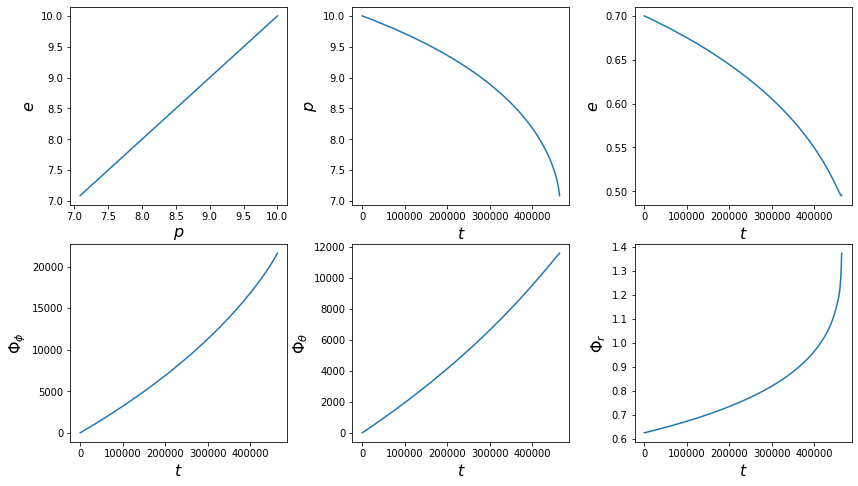

In [5]:
fig, axes = plt.subplots(2, 3)
plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(14, 8)
axes = axes.ravel()

ylabels = [r'$e$', r'$p$', r'$e$', r'$\Phi_\phi$', r'$\Phi_\theta$', r'$\Phi_r$']
xlabels = [r'$p$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$', r'$t$']
ys = [p, p, e, Phi_phi, Phi_r, flux]
xs = [p, t, t, t, t, t]

for i, (ax, x, y, xlab, ylab) in enumerate(zip(axes, xs, ys, xlabels, ylabels)):
    ax.plot(x, y)
    ax.set_xlabel(xlab, fontsize=16)
    ax.set_ylabel(ylab, fontsize=16)

### Defining a new t vector

../few/utils/baseclasses.py:366: UserWarning: new_t array goes beyond generated t array. If you want to cut the t array at the end of the trajectory, set fix_t to True.
  "new_t array goes beyond generated t array. If you want to cut the t array at the end of the trajectory, set fix_t to True."


t1 max: 999999.0 t2 max: 464407.0


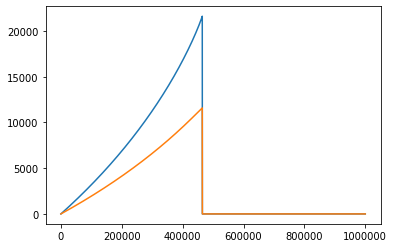

In [14]:
new_t = np.arange(0, 1e6, 1.0) 

# set initial parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7

# a warning will be thrown if the new_t array goes beyond the time array output from the trajectory
t1, p1, e1, Phi_phi1, Phi_r1, flux1 = traj(M, mu, p0, e0, new_t=new_t, upsample=True)

# you can cut the excess on these arrays by setting fix_t to True
t2, p2, e2, Phi_phi2, Phi_r2, flux2 = traj(M, mu, p0, e0, new_t=new_t, upsample=True, fix_t=True)

plt.plot(t1, Phi_phi1, label=r'$\Phi_\phi$')
plt.plot(t1, Phi_r1, label=r'$\Phi_r$')

print('t1 max:', t1.max(), 't2 max:', t2.max())


### Defining dt and T

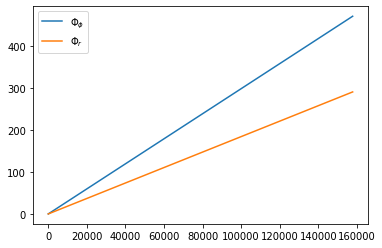

In [17]:
dt = 15.0
T = 0.005 # years

# set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.7

t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0, dt=dt, T=T, upsample=True)

plt.plot(t, Phi_phi, label=r'$\Phi_\phi$')
plt.plot(t, Phi_r, label=r'$\Phi_r$')
plt.legend()

In [18]:
t.max()

157800.0

### Getting dimensionless time ($t/M$)

Dimensionless time step: 20.30254435170025


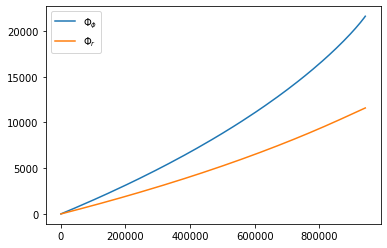

In [16]:
# set initial parameters
M = 1e5
mu = 1e1
p0 = 10.0
e0 = 0.7

t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0, in_coordinate_time=False)

plt.plot(t, Phi_phi, label=r'$\Phi_\phi$')
plt.plot(t, Phi_r, label=r'$\Phi_r$')
plt.legend()
print('Dimensionless time step:', t[1] - t[0])

### Dense Stepping

In [3]:
# initialize trajectory class
dense_traj = RunSchwarzEccFluxInspiral(DENSE_STEPPING=1, max_input_len=int(1e7))

In [7]:
dt = 15.0
T = 0.005 # years

# set initial parameters
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.7

t, p, e, Phi_phi, Phi_r, flux = dense_traj(M, mu, p0, e0, dt=dt, T=T)

In [8]:
t.shape

(14,)

## Amplitude Module

The amplitude module generates the complex mode amplitudes for each harmonic mode requested, $A_{lmkn}(t)$ ($k=0$ for equatorial orbits). With Schwarzschild eccentric amplitudes, the user provides $p$ and $e$ as arrays and is returned the requested Teukolsky modes in a 2D array of shape (trajectory length, number of modes). 

### ROMAN amplitude generation

ROMAN uses a reduced order model representing the mode amplitude space. It then trains a neural network on this reduced model. The neural network is evaluated and the resulting matrix is transformed from the reduced basis back to the full mode space.  

In [2]:
# initialize ROMAN class
amp = RomanAmplitude(max_input_len=5000)  # max_input_len creates memory buffers

/Users/michaelkatz/anaconda3/envs/few_env/lib/python3.7/site-packages/few-0.1.0-py3.7-macosx-10.9-x86_64.egg/few/amplitude/romannet.py:80: UserWarning: The file SchwarzschildEccentricInput.hdf5 did not open sucessfully. It will now be downloaded to the proper location.
  "The file SchwarzschildEccentricInput.hdf5 did not open sucessfully. It will now be downloaded to the proper location."


Total trajectory points: 2500


Text(0, 0.5, 'e')

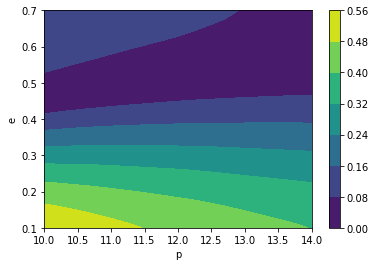

In [68]:
p = np.linspace(10.0, 14.0)
e = np.linspace(0.1, 0.7)

p_all, e_all = np.asarray([temp.ravel() for temp in np.meshgrid(p, e)])

print('Total trajectory points:', p_all.shape[0])
teuk_modes = amp(p_all, e_all)

# look at the contours of the (2,2,0) mode
cb = plt.contourf(p, e, np.abs(teuk_modes[:, amp.special_index_map[(2,2,0)]].reshape(len(p), len(e))))
plt.colorbar(cb)
plt.xlabel('p')
plt.ylabel('e')

Specific modes can be selected by providing a list of tuple of (l,m,n) values as the `specific_modes` kwarg:

Indices of interest: [ 640 1922]
True
True


Text(0, 0.5, 'e')

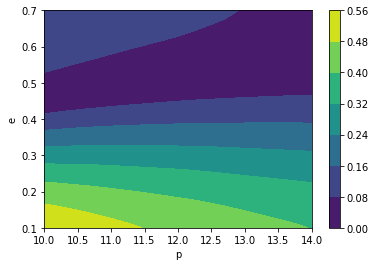

In [22]:
# (2, 2, 0) and (7, -3, 1) modes
specific_modes = [(2, 2, 0), (7, -3, 1)]

# notice this returns a dictionary with keys as the mode tuple and values as the mode values at all trajectory points
specific_teuk_modes = amp(p_all, e_all, specific_modes=specific_modes)

# we can find the index to these modes to check
inds = np.array([amp.special_index_map[lmn] for lmn in specific_modes])
print('Indices of interest:', inds)

# make sure they are the same
print(np.allclose(specific_teuk_modes[(2, 2, 0)], teuk_modes[:, inds[0]]))

# to check -m modes we need to take the conjugate
print(np.allclose(specific_teuk_modes[(7, -3, 1)], np.conj(teuk_modes[:, inds[1]])))

# look at the contours of the (220)mode
cb = plt.contourf(p, e, np.abs(specific_teuk_modes[(2, 2, 0)].reshape(len(p), len(e))))
plt.colorbar(cb)
plt.xlabel('p')
plt.ylabel('e')

### Interpolate modes with bicubic spline

For this amplitude generator, amplitudes are interpolated in 2D ($p$ and $e$) using bicubic splines. They are then evaluated for the desired modes. This is used to produce our slow waveform. This will also not scale well with dimensionality. **Note**: Specific modes can be selected in the same way as above.

In [6]:
# initialize class
amp2 = Interp2DAmplitude() 

Total trajectory points: 2500


Text(0, 0.5, 'e')

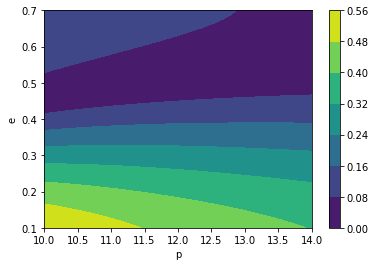

In [24]:
p = np.linspace(10.0, 14.0)
e = np.linspace(0.1, 0.7)

p_all, e_all = np.asarray([temp.ravel() for temp in np.meshgrid(p, e)])

print('Total trajectory points:', p_all.shape[0])

# to get all modes we can simply do this
teuk_modes = amp2(p_all, e_all)

# look at the contours of the (220) mode
cb = plt.contourf(p, e, np.abs(teuk_modes[:, amp2.special_index_map[(2,2,0)]].reshape(len(p), len(e))))
plt.colorbar(cb)
plt.xlabel('p')
plt.ylabel('e')

## Spin-weighted spherical harmonics

In [13]:
few = FastSchwarzschildEccentricFlux()  # get mode information

ylm_gen = GetYlms(few.num_teuk_modes, assume_positive_m=False, use_gpu=False)

ls = np.array([2, 3, 4, 5])
ms = np.array([2, 2, 3, 3])

# viewing angles
theta = np.pi/3
phi = np.pi/4

print(ylm_gen(ls, ms, theta, phi))

[ 2.17261840e-17+3.54815511e-01j -1.28533838e-17-2.09911687e-01j
  1.24292687e-16-1.24292687e-16j -2.46692086e-01+2.46692086e-01j]


If we assume positive m, it will return -m entries for all +m. The last 5 below are for -m. The final shape will be twice the initial length and will duplicate m=0 so be careful.

In [17]:
ylm_gen = GetYlms(few.num_teuk_modes, assume_positive_m=True, use_gpu=False)

ls = np.array([2, 3, 4, 5, 2])
ms = np.array([2, 2, 3, 3, 0])

# viewing angles
theta = np.pi/3
phi = np.pi/4

ylms = ylm_gen(ls, ms, theta, phi)

for l, m, ylm in zip(ls, ms, ylms[:5]):
    print('({},{}):'.format(l, m), ylm)
    
for l, m, ylm in zip(ls, ms, ylms[5:]):
    print('({},-{}):'.format(l, m), ylm)

(2,2): (2.1726183986132194e-17+0.35481551090908514j)
(3,2): (-1.2853383784425917e-17-0.2099116870819398j)
(4,3): (1.242926870060164e-16-1.2429268700601641e-16j)
(5,3): (-0.24669208642519044+0.2466920864251905j)
(2,0): (0.2897056515173922+0j)
(2,-2): (2.4140204429035754e-18-0.039423945656564985j)
(3,-2): (-9.997076276775717e-18+0.16326464550817543j)
(4,-3): (-0.12119256904280647-0.12119256904280648j)
(5,-3): (0.2357279936951819+0.23572799369518196j)
(2,-0): (0.2897056515173922+0j)


## Mode Selection

The mode selection module is paramount to the computational efficiency of this model. Below we show how we perform this selection operation by moving from a set of amplitudes to only those that contribute. 

In [27]:
# first, lets get amplitudes for a trajectory
traj = RunSchwarzEccFluxInspiral()

# parameters
M = 1e5
mu = 1e1
p0 = 11.0
e0 = 0.3
theta = np.pi/3.
phi = np.pi/2.

t, p, e, Phi_phi, Phi_r, flux = traj(M, mu, p0, e0)

# get amplitudes along trajectory
amp = RomanAmplitude()

teuk_modes = amp(p, e)

# get ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

# select modes

mode_selector = ModeSelector(amp.m0mask, use_gpu=False)

eps = 1e-5  # tolerance on mode contribution to total power

modeinds = [amp.l_arr, amp.m_arr, amp.n_arr]
(teuk_modes_in, ylms_in, ls, ms, ns) = mode_selector(teuk_modes, ylms, modeinds, eps=eps)

print("We reduced the mode content from {} modes to {} modes.".format(teuk_modes.shape[1], teuk_modes_in.shape[1]))

We reduced the mode content from 3843 modes to 583 modes.


The actual method/code used for the mode selection can be seen here:

In [34]:
# get the power in the teukolsky modes
power = (
    np.abs(
        np.concatenate(
            [teuk_modes, np.conj(teuk_modes[:, amp.m0mask])], axis=1
        )
        * ylms
    )
    ** 2
)

# sort and cumsum
inds_sort = np.argsort(power, axis=1)[:, ::-1]
power = np.sort(power, axis=1)[:, ::-1]
cumsum = np.cumsum(power, axis=1)

inds_keep = np.full(cumsum.shape, True)

# keep modes that contribute to within the threshold of the total power
# This is done independently at each time step
inds_keep[:, 1:] = cumsum[:, :-1] < cumsum[:, -1][:, np.newaxis] * (
    1 - eps
)

temp = inds_sort[inds_keep]

# adjust for indices with -m modes
temp = temp * (temp < amp.num_m_zero_up) + (temp - amp.num_m_1_up) * (
    temp >= amp.num_m_zero_up
)

# take the union of all contributing modes over all time steps
keep_modes = np.unique(temp)

# set up for ylms
temp2 = keep_modes * (keep_modes < amp.num_m0) + (
    keep_modes + amp.num_m_1_up
) * (keep_modes >= amp.num_m0)

# adjust for -m modes
ylmkeep = np.concatenate([keep_modes, temp2])

# arrays kept
out1 = (teuk_modes[:, keep_modes], ylms[ylmkeep])

# mode indexes kept
out2 = tuple([arr[keep_modes] for arr in modeinds])

teuk_modes_in, ylms_in, ls, ms, ns = out1 + out2

print(np.array([ls, ms, ns]).T, len(ls))

[[  2   0 -30]
 [  2   0 -29]
 [  2   0 -28]
 ...
 [ 10  10  28]
 [ 10  10  29]
 [ 10  10  30]] 583


## Parallelized Cubic Spline Interpolation

A part of the Fast EMRI waveforms package is parallelized cubic spline interpolation. This generally means fitting and evaluating many splines in parallel with the same input x array. This is available for GPUs and CPUs (OMP). The user can perform this operation entirely in Python while leveraging [CuPy](https://cupy.dev/) for GPUs. However, the evaluation will not be as efficient as when it is implemented properly in a customized kernel. The spline class ([CubicSplineInterpolant](https://mikekatz04.github.io/FastEMRIWaveforms/html/index.html?highlight=modeselector#few.summation.interpolatedmodesum.CubicSplineInterpolant)) can provide an 1D flattened array of all spline coefficients for use in a custom CUDA kernel. 

In [50]:
# let's take the amplitudes from the last step and spline those. 
# We have to arange everything in the shape (ninterps, length)
# We will split real and imaginary components

teuk_modes

interp_in = np.zeros((teuk_modes.shape[1] * 2, teuk_modes.shape[0]))
                     
interp_in[:teuk_modes.shape[1], :] = teuk_modes.T.real
interp_in[teuk_modes.shape[1]:, :] = teuk_modes.T.imag

spline = CubicSplineInterpolant(t, interp_in)

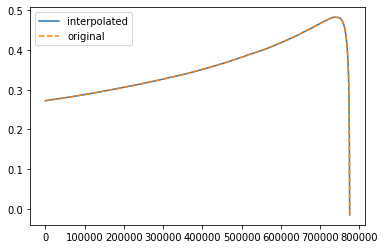

In [63]:
# get new values
t_new = np.linspace(t[0], t[-1], 1000)

# notice the new shape is (ninterps, length) just like the inital input to the spline
new_teuk_modes = spline(t_new)

# (220) mode (real part)
ind = amp.special_index_map[(2, 2, 0)]

plt.plot(t_new, new_teuk_modes[ind], label='interpolated')
plt.plot(t, teuk_modes[:, ind].real, '--', label='original')
plt.legend()

To get the array of interp coefficients for CUDA implementations, do the following. The underlying shape of the array is (4, length, ninterps). It is flattened though for entry into GPU kernel. 

In [61]:
spline.interp_array

array([-3.54810537e-05, -4.01422809e-05, -4.48887306e-05, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

## Mode Summation

Mode summation 

## Creating your own modules!

In addition to using our built-in modules and waveforms, you can easily create your own module or waveform. Below is an example of creating your own trajectory module and using it in a custom waveform. If you can get a reasonably fast trajectory from your specific brand of EMRI physics, you can be generating waveforms in no time! Please see the [documentation]() on this for more details on the constructions behind this. 

**Important Note**: If you do use this package to examine EMRI analysis problems, please contact the authors of this code (see docs) about possible collaboration and/or contribution.

### Post-Newtonian trajectory

The example will be to implement a Post-Newtonian trajectory in a Schwarzschild eccentric waveform. This will be done purely in Python. However, most of our modules have backends in C/C++/CUDA for maximum efficiency. If you have a trajectory in python and want to see if it can be ported for speed, please contact the authors.

To get started, we will import an integrator ([DOP853](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.DOP853.html#scipy.integrate.DOP853)) and a library for elliptical integrals that mirrors the mathematica format `mpmath`. You can run: 

```
pip install mpmath
```

in your conda environment to attain that library. 

We will also import necessary things from our package. This includes constants from `few.utils.constants`, as well as two base classes to be inherited by the new module. 

The first base class is [SchwarzschildEccentric](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/main.html#few.utils.baseclasses.SchwarzschildEccentric) base class that passes information specific to any Schwarzschild eccentric waveform (number of modes, (l,m,n) pairs, etc.). It also has methods for general sanity checks in these limits for input parameters, trajectories, and other things. You can see the documentation for more detail on its properties. 

The other base class is [TrajectoryBase](file:///Users/michaelkatz/Research/FastEMRIWaveforms/docs/html/user/traj.html#few.utils.baseclasses.TrajectoryBase). This houses both information for trajectory modules, as well as the interface that should be common to all trajectory modules (i.e. [__call__](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/traj.html?highlight=trajectorybase#few.utils.baseclasses.TrajectoryBase.__call__) function). It allows for flexible parameter calling interfaces, but ensures the strict interface will be the same for all trajectory modules. Trajectory modules must implement the method [get_inspial](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/traj.html?highlight=trajectorybase#few.utils.baseclasses.TrajectoryBase.get_inspiral). The common interface uses this to generate the specific trajectory. 

This is a common theme amongst module and waveform creation. The user will take one parent abstract base class related to the waveform limits, domain of validity, and its waveform properties, and one parent abstract based class for the module type (like trajectory or summation). 

In [2]:
# we need to import an integrator and elliptic integrals
from mpmath import *
from scipy.integrate import DOP853

# base classes
from few.utils.baseclasses import TrajectoryBase
from few.utils.baseclasses import SchwarzschildEccentric

# settings for elliptic integrals
mp.dps = 25
mp.pretty = True

# constants from our package
from few.utils.constants import MTSUN_SI, YRSID_SI, Pi

# for common interface with C/mathematica
def Power(x, n):
    return x**n

def Sqrt(x):
    return np.sqrt(x)

# this is class object just to hold epsilon as it steps
# this class is instantiated and then run like the derivative function in the integrator (ex. dydt)
class PN:
    def __init__(self, epsilon):
        self.epsilon = epsilon

    def __call__(self, t, y):

        # mass ratio
        epsilon = self.epsilon

        # extract the four evolving parameters
        p, e, Phi_phi, Phi_r = y
        
        # guard against bad integration steps
        if e >= 1.0 or e < 1e-2 or p < 6.0 or (p - 6 - 2* e) < 0.1:
            return [0.0, 0.0]
        

        # perform elliptic calculations
        EllipE 	= ellipe(4*e/(p-6.0+2*e))
        EllipK 	= ellipk(4*e/(p-6.0+2*e))
        EllipPi1 = ellippi(16*e/(12.0 + 8*e - 4*e*e - 8*p + p*p), 4*e/(p-6.0+2*e))
        EllipPi2 = ellippi(2*e*(p-4)/((1.0+e)*(p-6.0+2*e)), 4*e/(p-6.0+2*e))

        # Azimuthal frequency
        Omega_phi = (2*Power(p,1.5))/(Sqrt(-4*Power(e,2) + Power(-2 + p,2))*(8 + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
              (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/
            (EllipK*Power(-4 + p,2))))

        # Post-Newtonian calculations
        yPN = pow(Omega_phi,2./3.)

        EdotPN = (96 + 292*Power(e,2) + 37*Power(e,4))/(15.*Power(1 - Power(e,2),3.5)) * pow(yPN, 5)
        LdotPN = (4*(8 + 7*Power(e,2)))/(5.*Power(-1 + Power(e,2),2)) * pow(yPN, 7./2.)

        # flux
        Edot = -epsilon*(EdotPN)
        Ldot = -epsilon*(LdotPN)

        # time derivatives
        pdot = (-2*(Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*(3 + Power(e,2) - p)*Power(p,1.5) + Ldot*Power(-4 + p,2)*Sqrt(-3 - Power(e,2) + p)))/(4*Power(e,2) - Power(-6 + p,2))

        edot = -((Edot*Sqrt((4*Power(e,2) - Power(-2 + p,2))/(3 + Power(e,2) - p))*Power(p,1.5)*
        (18 + 2*Power(e,4) - 3*Power(e,2)*(-4 + p) - 9*p + Power(p,2)) +
        (-1 + Power(e,2))*Ldot*Sqrt(-3 - Power(e,2) + p)*(12 + 4*Power(e,2) - 8*p + Power(p,2)))/
        (e*(4*Power(e,2) - Power(-6 + p,2))*p))
        
        Phi_phi_dot = Omega_phi;

        Phi_r_dot = (p*Sqrt((-6 + 2*e + p)/(-4*Power(e,2) + Power(-2 + p,2)))*Pi)/(8*EllipK + ((-2*EllipPi2*(6 + 2*e - p)*(3 + Power(e,2) - p)*Power(p,2))/((-1 + e)*Power(1 + e,2)) - (EllipE*(-4 + p)*Power(p,2)*(-6 + 2*e + p))/(-1 + Power(e,2)) +
        (EllipK*Power(p,2)*(28 + 4*Power(e,2) - 12*p + Power(p,2)))/(-1 + Power(e,2)) + (4*(-4 + p)*p*(2*(1 + e)*EllipK + EllipPi2*(-6 - 2*e + p)))/(1 + e) + 2*Power(-4 + p,2)*(EllipK*(-4 + p) + (EllipPi1*p*(-6 - 2*e + p))/(2 + 2*e - p)))/Power(-4 + p,2))

        dydt = [pdot, edot, Phi_phi_dot, Phi_r_dot]

        return dydt

    
# this is the actual class that implements a PN trajectory. It uses the PN class in the integrator.
class PnTrajectory(TrajectoryBase):
    
    # for common interface with *args and **kwargs
    def __init__(self, *args, **kwargs):
        pass
    
    # required by the trajectory base class
    def get_inspiral(self, M, mu, p0, e0, T=1.0, **kwargs):

        # set up quantities and integrator
        y0 = [p0, e0, 0.0, 0.0]

        T = T * YRSID_SI / (M * MTSUN_SI)

        epsilon = mu/M
        integrator = DOP853(PN(epsilon), 0.0, y0, T)

        t_out, p_out, e_out = [], [], []
        Phi_phi_out, Phi_r_out = [], []
        
        # run the integrator down to T or separatrix
        run = True
        while integrator.t < T and run:
            integrator.step()
            p, e, Phi_phi, Phi_r = integrator.y
            t_out.append(integrator.t)
            p_out.append(p)
            e_out.append(e)
            Phi_phi_out.append(Phi_phi)
            Phi_r_out.append(Phi_r)

            if (p - 6 -2*e) < 0.1:
                run = False

        # read out data. It must return length 6 tuple
        t = np.asarray(t_out)
        p = np.asarray(p_out)
        e = np.asarray(e_out)
        Phi_phi = np.asarray(Phi_phi_out)
        Phi_r = np.asarray(Phi_r_out)
        flux = np.zeros_like(t)

        return (t, p, e, Phi_phi, Phi_r, flux)

### Test your trajectory!

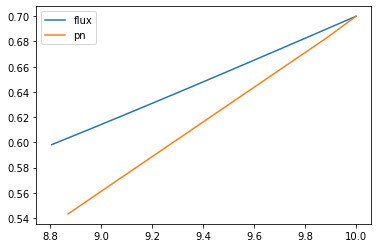

In [3]:
M = 1e6
mu = 1e1
p0 = 10.0
e0 = 0.7
T = 1.0

traj = PnTrajectory()

test = traj(M, mu, p0, e0, T=T, dt=10.0)

traj2 = RunSchwarzEccFluxInspiral()

flux = traj2(M, mu, p0, e0, T=T, dt=10.0)

p = test[1]
e = test[2] 

import matplotlib.pyplot as plt
plt.plot(flux[1], flux[2], label='flux')
plt.plot(p, e, label='pn')


plt.legend()
plt.savefig('trajectory_pn_vs_flux.pdf', dpi=200)


### Make a waveform model

Now we will create a waveform with our new trajectory model. To do this, we will start with [SchwarzschildEccentricWaveformBase](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/main.html#few.waveform.SchwarzschildEccentricWaveformBase). This base class has already inherited from [SchwarzschildEccentric](https://mikekatz04.github.io/FastEMRIWaveforms/html/user/main.html#few.utils.baseclasses.SchwarzschildEccentric). It creates the common interface for all waveform modules (and how they interface with there constituent modules). A requirement when creating a module is to have properties describing the GPU capability of the waveform, as well as whether or not it allows for batching the waveform creation (after trajectory).  

In [41]:
class FastSchwarzschildEccentricPn(SchwarzschildEccentricWaveformBase):
    def __init__(
        self,
        inspiral_kwargs={},
        amplitude_kwargs={},
        sum_kwargs={},
        Ylm_kwargs={},
        use_gpu=False,
        *args,
        **kwargs
    ):

        SchwarzschildEccentricWaveformBase.__init__(
            self,
            PnTrajectory,
            RomanAmplitude,
            InterpolatedModeSum,
            inspiral_kwargs=inspiral_kwargs,
            amplitude_kwargs=amplitude_kwargs,
            sum_kwargs=sum_kwargs,
            Ylm_kwargs=Ylm_kwargs,
            use_gpu=use_gpu,
            *args,
            **kwargs
        )

    @property
    def gpu_capability(self):
        return True

    @property
    def allow_batching(self):
        return False

### Test it!

It will have the same interface as the other waveforms. 

mismatch: 1.001340224043205


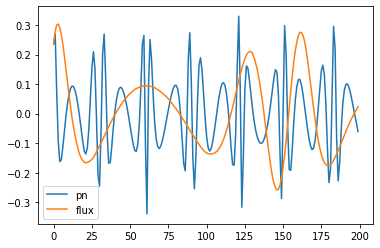

In [43]:
test = FastSchwarzschildEccentricPn(normalize_amps=False)

M = 1e6
mu = 1e1
p0 = 12.0
e0 = 0.4
theta = np.pi/3.
phi = np.pi/4.

T = 0.2
dt = 15.0

wave1 = test(M, mu, p0, e0, theta, phi, dt=dt, T=T)

wave2 = few(M, mu, p0, e0, theta, phi, dt=dt, T=T)

plt.plot(wave1.real[:200], label='pn')
plt.plot(wave2.real[:200], label='flux')
plt.legend()
print('mismatch:', get_mismatch(wave1, wave2))
plt.savefig('pn_vs_flux.pdf', dpi=200)